The propose of this script is to generate different plots between January and July for getting Bottom Particles patterns and proportions of each Particle through time. In this case we are not varying the input of Particles through time, but just releasing them at one moment in time to see their evolution.
- Here we want to try and represent the variability between Winter and Summer related of the amount of particles discharge between these months 

In [1]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable, Kernel, AdvectionRK4

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy import crs, feature
import zarr 

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def get_WW3_path(date):
    """Construct WW3 results path given the date
    e.g., /opp/wwatch3/nowcast/SoG_ww3_fields_YYYYMMDD_YYYYMMDD.nc
    :arg date: date of WW3 record
    :type date: :py:class:`datetime.datetime`
    :returns: WW3 path
    :rtype: str
    """
    # Make WW3 path
    path = '/opp/wwatch3/hindcast'
    path2 = '/opp/wwatch3/nowcast'
    datestr = [date.strftime(fmt) for fmt in ('%d%b%y', '%Y%m%d_%Y%m%d')]
    path = os.path.join(path, datestr[0].lower(), f'SoG_ww3_fields_{datestr[1]}.nc')
    if not os.path.exists(path):
        path = os.path.join(path2, datestr[0].lower(), f'SoG_ww3_fields_{datestr[1]}.nc')
        if not os.path.exists(path):    
            raise ValueError(f"No WW3 record found for the specified date {date.strftime('%Y-%b-%d')}")

    return path

In [3]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs',
'home': '/home/vvalenzuela/MOAD/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/animations'}

In [4]:
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])

In [5]:
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return np.array(timestamps, dtype='datetime64')

def find_temp(rootdir):
    dirs=[]
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            dirs.append(d)
    temp=sorted(dirs, key=lambda x: os.path.getctime(x), reverse=True)[:1][0]
    return temp[-12:]

def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
- First, we pick January 15th and run for a certain amount of particles through 30 days
- Second, we pick July 15th and run for a certain bigger amount of particles through 30 days 

With this we aim to look at daily proportions of particles at each state!

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


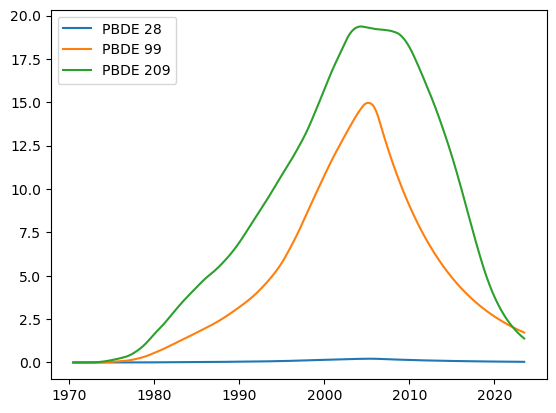

In [6]:
data_PBDE = pd.read_excel('/ocean/vvalenzuela/MOAD/analysis-vicente/PBDEs_DATA/predicted_discharges.xlsx')
data_PBDE = data_PBDE.set_index(data_PBDE['Unnamed: 0'].values)
data_PBDE.drop('Unnamed: 0', axis=1, inplace=True)
#
plt.plot(data_PBDE['PBDE 28'], label = 'PBDE 28')
plt.plot(data_PBDE['PBDE 99'], label = 'PBDE 99')
plt.plot(data_PBDE['PBDE 209'], label = 'PBDE 209')
#
plt.legend()

In [7]:
data_year_high = data_PBDE.loc['2005']
data_year_low = data_PBDE.loc['2020']

# Calculate monthly averages for 2000
monthly_avg_low = data_year_low.resample('M').mean()
monthly_avg_high = data_year_high.resample('M').mean()

print(monthly_avg_high)
print(monthly_avg_low)

             PBDE 28    PBDE 99   PBDE 209
2005-01-31  0.216660  14.961482  19.316538
2005-02-28  0.216903  14.968172  19.308710
2005-03-31  0.217065  14.968710  19.300712
2005-04-30  0.217151  14.963037  19.292273
2005-05-31  0.217153  14.950991  19.283661
2005-06-30  0.217073  14.932705  19.274883
2005-07-31  0.216902  14.907509  19.266058
2005-08-31  0.216598  14.872035  19.257549
2005-09-30  0.216163  14.826772  19.249751
2005-10-31  0.215594  14.771253  19.242514
2005-11-30  0.214892  14.705694  19.235818
2005-12-31  0.214057  14.630087  19.229657
             PBDE 28   PBDE 99  PBDE 209
2020-01-31  0.052700  2.638638  3.746205
2020-02-29  0.052267  2.612172  3.658525
2020-03-31  0.051837  2.585974  3.572919
2020-04-30  0.051404  2.559607  3.487923
2020-05-31  0.050975  2.533510  3.404960
2020-06-30  0.050549  2.507678  3.323960
2020-07-31  0.050126  2.482110  3.244897
2020-08-31  0.049700  2.456390  3.166459
2020-09-30  0.049285  2.431344  3.091133
2020-10-31  0.048873  2.406555 

**Comment:** The difference is not that big, so it would be a good idea to compare same month in different years with a bigger difference in the amount of particles that are being released

Let's do 6 runs: 
- January 15th and 300 Particles for 30 days
- July 15th and 250 Particles for 30 days
- January 15th with the amount of particles according to the year 2005, for 30 days
- July 15th with the amount of particles according to the year 2005, for 30 days
- January 15th with the amount of particles according to the year 2020, for 30 days
- July 15th with the amount of particles according to the year 2020, for 30 days

In [8]:
amount_2005 = 15 * 100
amount_2020 = 3 * 100

In [9]:
#Definitions
start = datetime(2022, 1, 1) #Start date
length = 365 # Set Time length [days] 
dt = 90 #toggle between - or + to pick backwards or forwards 
N = 1 # 1000   # number of  locations
# Here the number of particles needs to be associated to the discharge rates from the Iona Outfall
n = amount_2005#200 # number of particles per location
dmin = 60#minimum depth
dd = 20 #max depth difference from dmin
dtp = 0
odt = 1 #mins
rrr = 1e3

In [10]:
# function to get grid point gridX and gridY
path_NEMO = make_prefix(start,path['NEMO'])
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [11]:
#Set deploy coordinates following yaml   
clat = [49.195045]
clon = [-123.301956]
#
a, b = finder(clat[0], clon[0])
print ("The total depth at this location is", mask.totaldepth[a, b].values, 'm')
#
duration = timedelta(days=length)
#
x_offset, y_offset, z = p_deploy(N,n,dmin,dd,rrr)
#
lon = np.zeros([N,n])
lat = np.zeros([N,n])
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])

The total depth at this location is 85.375 m


In [12]:
# Files for states runs
name_states = 'Test_run_PBDEs_'+str(length)+'_days_'+str(n)+'_particles_' 
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name_states + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile_states = os.path.join(path['out'], fn)
#
local = 0

In [13]:
varlist=['U','V','W']
filenames,variables=filename_set(start,length,varlist)
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}
field_set=FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True, chunksize='auto')

#Find file names and variable names ###'Diat','Flag'###
varlist=['US','VS','WL','R','T','S','ssh','Bathy','Kz','totdepth','Vol','last_cell_index']
filenames,variables=filename_set(start,length,varlist)
dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht', 'time': 'time_counter'}
density = Field.from_netcdf(filenames['R'], variables['R'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(density)
#
#Add Vertical diffusivity coefficient field
dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'depthw','time': 'time_counter'}
Kz = Field.from_netcdf(filenames['Kz'], variables['Kz'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Kz)
#
#Add Bathymetry 2D field
dimensions = {'lon': 'glamt', 'lat': 'gphit'}
Bth = Field.from_netcdf(filenames['Bathy'], variables['Bathy'], dimensions,allow_time_extrapolation=True, chunksize='auto')
TD = Field.from_netcdf(filenames['totdepth'], variables['totdepth'], dimensions,allow_time_extrapolation=True, chunksize='auto')
MBATHY = Field.from_netcdf(filenames['last_cell_index'], variables['last_cell_index'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(MBATHY)
field_set.add_field(Bth)
field_set.add_field(TD)
#
#Add SSH 
dimensions = {'lon': 'glamt', 'lat': 'gphit','time': 'time_counter'}
SSH = Field.from_netcdf(filenames['ssh'], variables['ssh'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(SSH)
#
# Add e3t
varlist = ['cell_size']
filenames,variables=filename_set(start,length,varlist)
dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht', 'time': 'time_counter'}
E3T = Field.from_netcdf(filenames['cell_size'], variables['cell_size'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(E3T)
#

/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:511: FileWarning: File /ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc could not be decoded properly by xarray (version 2024.3.0). It will be opened with no decoding. Filling values might be wrongly parsed.
  with _grid_fb_class(lonlat_filename, dimensions, indices, netcdf_engine) as filebuffer:
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:511: FileWarning: File /ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc could not be decoded properly by xarray (version 2024.3.0). It will be opened with no decoding. Filling values might be wrongly parsed.
  with _grid_fb_class(lonlat_filename, dimensions, indices, netcdf_engine) as filebuffer:
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:511: FileWarning: File /ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc could not be decoded prope

In [14]:

####################################################### ADD IF USING POC or DOC###################################################################
# Fieldest for PON 
#varlist=['PON', 'DIATO', 'FLAGE']
#filenames, variables = filename_set(start, length, varlist)
#dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'deptht','time': 'time_counter'}
#PON=Field.from_netcdf(filenames['PON'], variables['PON'], dimensions, allow_time_extrapolation=True, chunksize='auto')
#DIATO=Field.from_netcdf(filenames['DIATO'], variables['DIATO'], dimensions, allow_time_extrapolation=True, chunksize='auto')
#FLAGE=Field.from_netcdf(filenames['FLAGE'], variables['FLAGE'], dimensions, allow_time_extrapolation=True, chunksize='auto')
#
#field_set.add_field(PON)
#field_set.add_field(DIATO)
#field_set.add_field(FLAGE)

In [15]:
# Define PARTICLE TYPE and variables within itself
class MPParticle(JITParticle):    
    n = Variable('n', initial = n)
    vvl_factor = Variable('fact', initial =  1)    
    wa = Variable('wa', initial =  0) 
    wm = Variable('wm', initial =  0)
    initialized = Variable('initialized', initial = 0)
    status = Variable('status', initial =  1) # different status for different processes
    #RE_MP = Variable('RE_MP', initial =  0)    
    #RE_C = Variable('RE_C', initial =  0)

In [16]:
pset_states = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))

$$\textbf{Kernels!}$$

In [17]:
# Just for the beginning, not at every time!!
def states(particle, fieldset, time):
    if particle.initialized == 0:
        n = particle.n 
        # n is the total amount of particles released at the starting location
        data = ParcelsRandom.randint(0, n-1)
       # print('States Kernel is Running')

        #
        # PBDEs as Sewage Particles
        if data < 3*(n/4):
            particle.status = 1
            #print('Particle in Status 1')
        #
        # Colloidal/Dissolved PBDEs
        else:
            particle.status = 2
            #print('Particle in Status 2')
        #
        particle.initialized = 1    

In [18]:
def process(particle, fieldset, time):
# After PBDEs are out from the pipe, they can absorbe into marine particles. 
# And , from marine particles they can desorbe into colloidal/dissolved PBDEs
    abso = 0.038/24 #0.3
    deso_s = 3.2/24 #0.2
    deso_m = 1.6/24 #0.1
    dt = 1
    #print('Process Kernel is Running')

    if particle.initialized == 1:
        value = ParcelsRandom.random()
        if particle.status == 1 and value < (deso_s * dt):
            particle.status = 2
            #print('Particle from Status 1 to Status 2')

            # From Sewage Particle to Colloidal/Dissolved PBDE form
        elif particle.status == 2 and value < (abso * dt):
            particle.status = 3
            #print('Particle from Status 2 to Status 3')
            # From Coloidal/Dissolved form to being attached to a Marine Particle           
        elif particle.status == 3 and value < (deso_m * dt):
            particle.status = 2
            #print('Particle from Status 3 to Status 2')
            # From a Marine Particle to a Colloidal/Dissolved form                

In [19]:
def PBDEs_forms(particle, fieldset, time):
    #print('PBDEs_forms Kernel is Running')
    #### Lets say that the sinking rate of Sewage Particles is 3 times faster than the one for Marine Particles ####
    # Sinking velocity for PBDEs in sewage particles
    if particle.status == 1:
        sinkvel = 1
        particle.depth += sinkvel * particle.dt
    # Sinking velocity when colloids (just float around)        
    elif particle.status == 2:
        sinkvel = 0.0
        particle.depth += sinkvel * particle.dt
    # Sinking velocity for PBDEs in marine particles
    elif particle.status == 3:
        sinkvel = 0.36
        particle.depth += sinkvel * particle.dt 
    


In [20]:
def Advection(particle, fieldset, time): 
    # Advection Kernel for particles in any state apart from status == 4 (at the bottom)
    #
    if particle.status == 1 or particle.status == 2 or particle.status == 3:
        ssh = fieldset.sossheig[time, particle.depth, particle.lat, particle.lon] #SSH(t) sea surface height
        sshn = fieldset.sossheig[time+particle.dt, particle.depth, particle.lat, particle.lon] #SSH(t+dt) sea surface height in the next time step
        td = fieldset.totaldepth[time, particle.depth, particle.lat, particle.lon]#Total_depth 
        particle.fact = (1+ssh/td)
        VVL = (sshn-ssh)*particle.depth/(td+ssh)
        (u1, v1, w1) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon]
        lon1 = particle.lon + u1*.5*particle.dt
        lat1 = particle.lat + v1*.5*particle.dt
        dep1 = particle.depth + w1*.5*particle.dt/particle.fact
        (u2, v2, w2) = fieldset.UVW[time + .5 * particle.dt, dep1, lat1, lon1]
        lon2 = particle.lon + u2*.5*particle.dt
        lat2 = particle.lat + v2*.5*particle.dt
        dep2 = particle.depth + w2*.5*particle.dt/particle.fact
        (u3, v3, w3) = fieldset.UVW[time + .5 * particle.dt, dep2, lat2, lon2]
        lon3 = particle.lon + u3*particle.dt
        lat3 = particle.lat + v3*particle.dt
        dep3 = particle.depth + w3*particle.dt/particle.fact
        (u4, v4, w4) = fieldset.UVW[time + particle.dt, dep3, lat3, lon3]
        wa = (w1 + 2*w2 + 2*w3 + w4) /6.
        particle.wa = wa* particle.dt
        particle_dlon = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle_dlat = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
        particle_ddepth = particle.wa/particle.fact + VVL
        if particle_ddepth + particle.depth < 0:
            particle_ddepth = - (particle_ddepth+particle.depth)
    else:
        particle_dlon = 0
        particle_dlat = 0
        particle_ddepth = 0

In [21]:
def turb_mix(particle,fieldset,time):
    #print('Turb_mix Kernel is Running')
    if particle.status == 1 or particle.status == 2 or particle.status == 3:
        """Vertical mixing"""
        #Vertical mixing
        if particle.depth + 0.5/particle.fact > td: #Only calculate gradient of diffusion for particles deeper than 0.5 otherwise OP will check for particles outside the domain and remove it.
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth-0.5/particle.fact, particle.lat, particle.lon]) #backwards difference 
        else: 
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth+0.5/particle.fact, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]) #forward difference 
        dgrad = Kzdz*particle.dt/particle.fact
        if particle.depth+(0.5*dgrad) > 0 and particle.depth+(0.5*dgrad) < td:
            Kz = fieldset.vert_eddy_diff[time, particle.depth+ 0.5*dgrad, particle.lat, particle.lon] #Vertical diffusivity SSC  
        else:
            Kz = 0#fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon] 

        Rr = ParcelsRandom.uniform(-1, 1)
        d_random = sqrt(3*2*Kz*particle.dt) * Rr/particle.fact
        dzs = (dgrad + d_random)
        particle.wm = dzs*particle.fact

In [22]:
def Displacement(particle,fieldset,time):
    #print('Displacement Kernel is Running')
    '''Apply movement calculated by other kernels'''
    if particle.status == 1 or particle.status == 2 or particle.status == 3: # or particle.status == 5 or particle.status == 6:
        #Apply turbulent mixing.
        if dzs + particle_ddepth + particle.depth > td:
            particle.depth  = td # Get particles attached to the bottom when they reach it
            particle.status = 4
            #print('Particle reached the bottom (Status 4)')
        #
        elif dzs + particle.depth+ particle_ddepth < 0:
            particle_ddepth = -(dzs + particle.depth+particle_ddepth) #reflection on surface
        #
        else:
            particle_ddepth += dzs #apply mixing 

Idea behind resuspenssion Kernel:

- After particles are setteld at the bottom, reaching status 4, if bottom velocities reach a critical value, then PBDEs are resuspended in the form of Colloids (Status = 2), being scavanged away. A part is also resuspended in Particulate form, but since they sink really fast, then we can neglect it.

- 'Question': How can we set it up? What do we need for this Kernel? (checked) :D

In [23]:
def resuspension(particle, fieldset, time):
    if particle.status == 4:
        threshold = 1 # threshold for particles to know when to resuspend
        # Calculation of U_star, which is proportional to the bottom stress (tau)
        k = 0.42
        z_star = 0.07
        u_horizontal = (1/4) * (fieldset.U[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat, particle.lon] + fieldset.U[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat, particle.lon -1]) ** 2
        v_horizontal = (1/4) * (fieldset.V[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat, particle.lon] + fieldset.U[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat - 1, particle.lon]) ** 2
        vel_horizontal = (u_horizontal + v_horizontal) ** (1/2)
 
        u_star = (vel_horizontal * k) / ((math.log(fieldset.e3t[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] -1, particle.lat, particle.lon] / 2) / z_star))
        # Here tau is the bottom friction parameter estimated from (u_starr)^2 x density
        tau = ((u_star) ** 2) * 1024#(fieldset.sigma_theta[particle.time, fieldset.mbathy - 1, particle.lat, particle.lon] + 1000)
        #
        #############
        frac_value = ParcelsRandom.randint(0,10)
        if tau > threshold and frac_value >= 3: # for colloids
            #particle.status = 5
            particle.status = 2
            #particle.RE_C = 1
            #print('Above Threshold!! Particle resuspended as colloid (Status 5)')
        #
        elif tau > threshold and frac_value < 3: # for marine particles
            #particle.status = 6
            particle.status = 3
            #particle.RE_MP = 1
            #print('Above Threshold!! Particle resuspended as particle (Status 6)')
        elif tau < threshold:
            particle.status = 4
            #particle.RE_MP = 0
            #particle.RE_C = 0
            #print('particles stays at the bottom, NOT BEING RESUSPENDED')    
            #
            #particle.depth += sinkvel * particle.dt     

##### ADD HOW PARTICLES WILL RESUSPEND #####

In [24]:
def export(particle,fieldset,time):
    if particle.lat<48.7 and particle.lon < -124.66:
        particle.status = 7

def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:    
        particle.delete()
        
def KeepInOcean(particle, fieldset, time):
    if particle.state == StatusCode.ErrorThroughSurface:
        particle.depth = 0.0
        particle.state = StatusCode.Success

In [25]:
pset_states.execute([states, process, PBDEs_forms, Advection, turb_mix, Displacement, resuspension, CheckOutOfBounds, export, KeepInOcean],
            runtime=duration/2, 
            dt=dt,
            output_file=pset_states.ParticleFile(name=outfile_states, outputdt=timedelta(hours=odt))) 

/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/ast.py:418: KernelWarning: Don't change the location of a particle directly in a Kernel. Use particle_dlon, particle_dlat, etc.
  return visitor(node)
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:1397: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_run_PBDEs_365_days_1500_particles_20220101_1n_20230101_1n.zarr.
100%|██████████| 15768000.0/15768000.0 [12:39:17<00:00, 346.12it/s]  


$$\textbf{Months Analysis}$$

Let's separate each dataset for independent analysis:

**January 15th and July 15th --> 300 and 200 particles repectively**

In [13]:
ds_jan = xr.open_zarr('/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_run_PBDEs_30_days_300_particles_20220115_1n_20220214_1n.zarr')
depth_jan = ds_jan.z*ds_jan.fact
date_jan_start = datetime(2022, 1, 15).strftime("%Y-%m-%d")
date_jan_end  = (datetime(2022, 1, 15) + timedelta(30)).strftime("%Y-%m-%d")
##############################################################################
ds_jul = xr.open_zarr('/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_run_PBDEs_30_days_200_particles_20220715_1n_20220814_1n.zarr')
depth_jul = ds_jul.z*ds_jul.fact
date_jul_start = datetime(2022, 7, 15).strftime("%Y-%m-%d")
date_jul_end  = (datetime(2022, 7, 15) + timedelta(30)).strftime("%Y-%m-%d")

(array([[176.,   0.,   0., ...,   0.,   0.,   0.],
        [185.,   0.,   0., ...,   0.,   0.,   0.],
        [186.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [ 49.,   0.,   0., ...,   0.,   0., 146.],
        [ 47.,   0.,   0., ...,   0.,   0., 146.],
        [ 47.,   0.,   0., ...,   0.,   0., 146.]]),
 array([2.        , 2.20000005, 2.4000001 , 2.5999999 , 2.79999995,
        3.        , 3.20000005, 3.4000001 , 3.5999999 , 3.79999995,
        4.        ]),
 <a list of 360 BarContainer objects>)

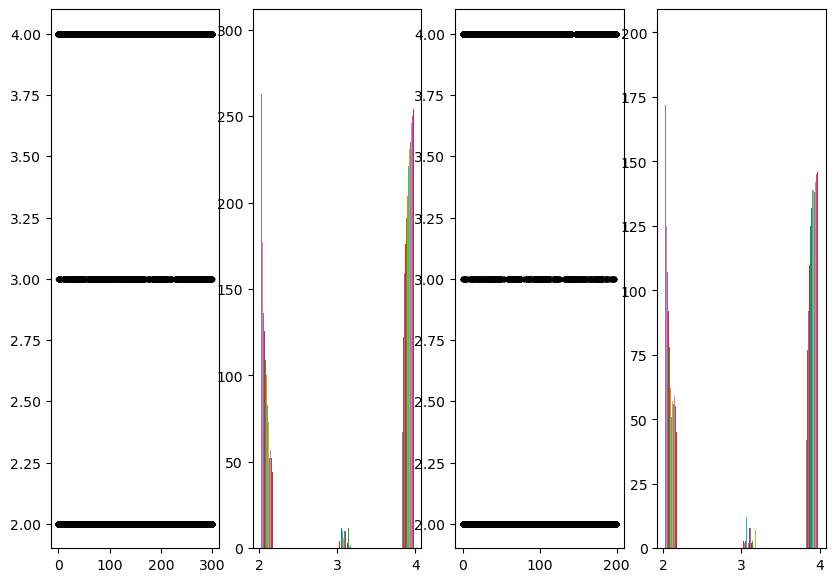

In [14]:
fig, ax = plt.subplots(1,4,figsize=(10,7))
ax[0].plot(ds_jan.status, '.k')
ax[1].hist(ds_jan.status)
#
ax[2].plot(ds_jul.status, '.k')
ax[3].hist(ds_jul.status)


**Spatial distribution of Particles at all times for January and July runs**

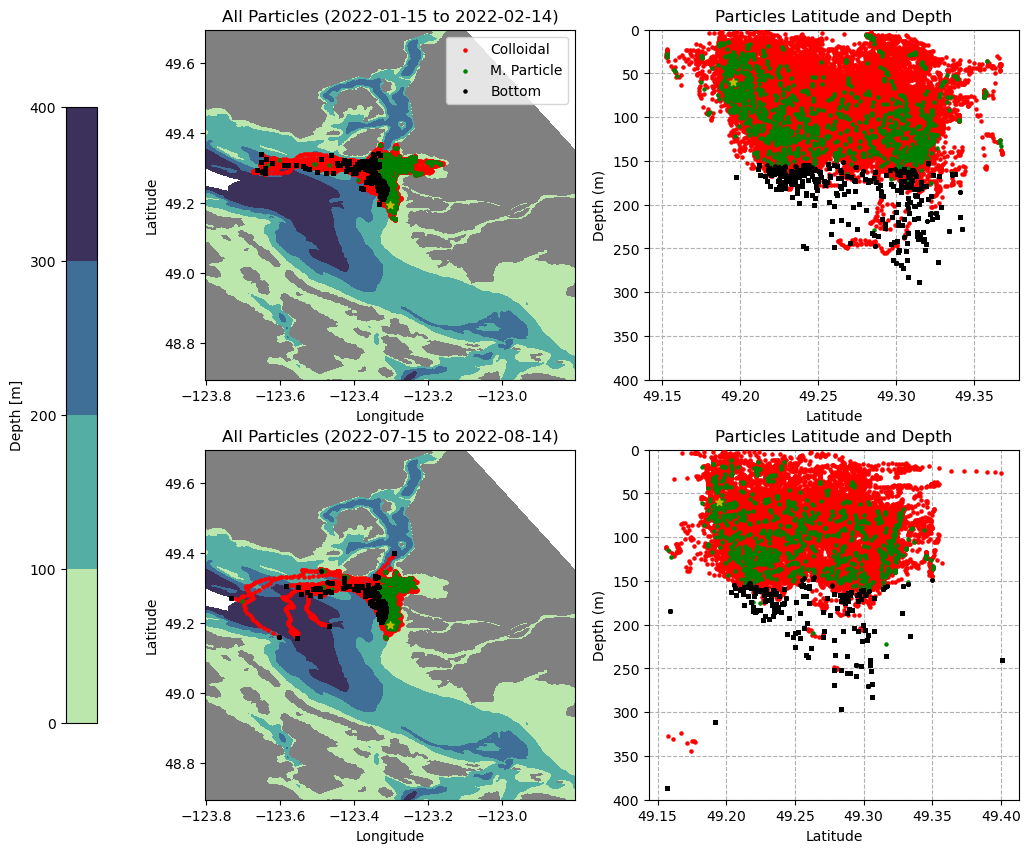

In [15]:
fig,axs=plt.subplots(2,2,figsize=(14,10))
# Make map
blevels = list(np.arange(0,500,100))

im=axs[0,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,0].scatter(ds_jan.lon.where(ds_jan.status == 2),ds_jan.lat.where(ds_jan.status == 2),zorder=3,c='r',s=5, label = 'Colloidal')
axs[0,0].scatter(ds_jan.lon.where(ds_jan.status == 3),ds_jan.lat.where(ds_jan.status == 3),zorder=3,c='g',s=5, label = 'M. Particle')
axs[0,0].scatter(ds_jan.lon.where(ds_jan.status == 4),ds_jan.lat.where(ds_jan.status == 4),zorder=3,c='k',s=5, label = 'Bottom')
#
axs[0,0].legend()
axs[0,0].scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs[0,0].set_ylim([clat[0]-.5,clat[0]+.5])
axs[0,0].set_xlim([clon[0]-.5,clon[0]+.5])
axs[0,0].set_title(f'All Particles ('+ str(date_jan_start) + ' to ' + str(date_jan_end)+ ')')
axs[0,0].set_xlabel('Longitude')
axs[0,0].set_ylabel('Latitude')
#
axs[0,1].scatter(ds_jan.lat.where(ds_jan.status == 2),depth_jan.where(ds_jan.status == 2),zorder=3,c='r',s=5)
axs[0,1].scatter(ds_jan.lat.where(ds_jan.status == 3),depth_jan.where(ds_jan.status == 3),zorder=3,c='g',s=5)
axs[0,1].scatter(ds_jan.lat.where(ds_jan.status == 4),depth_jan.where(ds_jan.status == 4),zorder=3,c='k',s=5)
#
axs[0,1].scatter(clat[0],dmin, zorder=3, c='y', marker='*',s=30)
axs[0,1].set_ylim([400,0])
axs[0,1].set_xlabel('Latitude')
axs[0,1].set_ylabel('Depth (m)')
axs[0,1].set_title(f'Particles Latitude and Depth')
axs[0,1].grid(linestyle = '--')
#
im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds_jul.lon.where(ds_jul.status == 2),ds_jul.lat.where(ds_jul.status == 2),zorder=3,c='r',s=5, label = 'Colloidal')
axs[1,0].scatter(ds_jul.lon.where(ds_jul.status == 3),ds_jul.lat.where(ds_jul.status == 3),zorder=3,c='g',s=5, label = 'M. Particle')
axs[1,0].scatter(ds_jul.lon.where(ds_jul.status == 4),ds_jul.lat.where(ds_jul.status == 4),zorder=3,c='k',s=5, label = 'Bottom')
#
axs[1,0].scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs[1,0].set_ylim([clat[0]-.5,clat[0]+.5])
axs[1,0].set_xlim([clon[0]-.5,clon[0]+.5])
axs[1,0].set_title(f'All Particles ('+ str(date_jul_start) + ' to ' + str(date_jul_end)+')')
axs[1,0].set_xlabel('Longitude')
axs[1,0].set_ylabel('Latitude')
#
axs[1,1].scatter(ds_jul.lat.where(ds_jul.status == 2),depth_jul.where(ds_jul.status == 2),zorder=3,c='r',s=5)
axs[1,1].scatter(ds_jul.lat.where(ds_jul.status == 3),depth_jul.where(ds_jul.status == 3),zorder=3,c='g',s=5)
axs[1,1].scatter(ds_jul.lat.where(ds_jul.status == 4),depth_jul.where(ds_jul.status == 4),zorder=3,c='k',s=5)
#
axs[1,1].scatter(clat[0],dmin, zorder=3, c='y', marker='*',s=30)
axs[1,1].set_ylim([400,0])
axs[1,1].set_xlabel('Latitude')
axs[1,1].set_ylabel('Depth (m)')
axs[1,1].set_title(f'Particles Latitude and Depth')
axs[1,1].grid(linestyle = '--')
#
cbar = fig.colorbar(im, ax=axs, location='left', shrink=0.8)
cbar.set_label('Depth [m]')
#

**Spatial distribution of Particles at final run time for January and July runs**

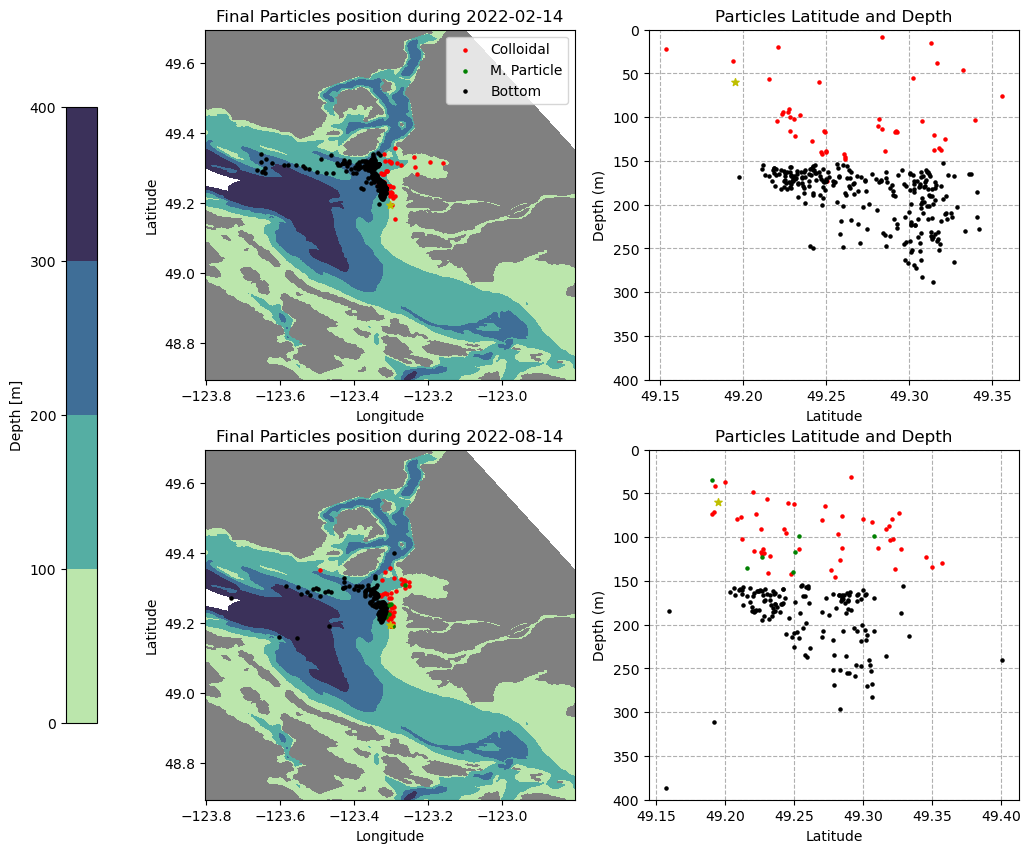

In [16]:
fig,axs=plt.subplots(2,2,figsize=(14,10))
# Make map
blevels = list(np.arange(0,500,100))

im=axs[0,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,0].scatter(ds_jan.lon[:,-1].where(ds_jan.status[:,-1] == 2),ds_jan.lat[:,-1].where(ds_jan.status[:,-1] == 2),zorder=3,c='r',s=5, label = 'Colloidal')
axs[0,0].scatter(ds_jan.lon[:,-1].where(ds_jan.status[:,-1] == 3),ds_jan.lat[:,-1].where(ds_jan.status[:,-1] == 3),zorder=3,c='g',s=5, label = 'M. Particle')
axs[0,0].scatter(ds_jan.lon[:,-1].where(ds_jan.status[:,-1] == 4),ds_jan.lat[:,-1].where(ds_jan.status[:,-1] == 4),zorder=3,c='k',s=5, label = 'Bottom')
#
axs[0,0].legend()
axs[0,0].scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs[0,0].set_ylim([clat[0]-.5,clat[0]+.5])
axs[0,0].set_xlim([clon[0]-.5,clon[0]+.5])
axs[0,0].set_title(f'Final Particles position during '+ str(date_jan_end))
axs[0,0].set_xlabel('Longitude')
axs[0,0].set_ylabel('Latitude')
#
axs[0,1].scatter(ds_jan.lat[:,-1].where(ds_jan.status[:,-1] == 2),depth_jan[:,-1].where(ds_jan.status[:,-1] == 2),zorder=3,c='r',s=5)
axs[0,1].scatter(ds_jan.lat[:,-1].where(ds_jan.status[:,-1] == 3),depth_jan[:,-1].where(ds_jan.status[:,-1] == 3),zorder=3,c='g',s=5)
axs[0,1].scatter(ds_jan.lat[:,-1].where(ds_jan.status[:,-1] == 4),depth_jan[:,-1].where(ds_jan.status[:,-1] == 4),zorder=3,c='k',s=5)
#
axs[0,1].scatter(clat[0],dmin, zorder=3, c='y', marker='*',s=30)
axs[0,1].set_ylim([400,0])
axs[0,1].set_xlabel('Latitude')
axs[0,1].set_ylabel('Depth (m)')
axs[0,1].set_title(f'Particles Latitude and Depth')
axs[0,1].grid(linestyle = '--')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds_jul.lon[:,-1].where(ds_jul.status[:,-1] == 2),ds_jul.lat[:,-1].where(ds_jul.status[:,-1] == 2),zorder=3,c='r',s=5, label = 'Colloidal')
axs[1,0].scatter(ds_jul.lon[:,-1].where(ds_jul.status[:,-1] == 3),ds_jul.lat[:,-1].where(ds_jul.status[:,-1] == 3),zorder=3,c='g',s=5, label = 'M. Particle')
axs[1,0].scatter(ds_jul.lon[:,-1].where(ds_jul.status[:,-1] == 4),ds_jul.lat[:,-1].where(ds_jul.status[:,-1] == 4),zorder=3,c='k',s=5, label = 'Bottom')
#
axs[1,0].scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs[1,0].set_ylim([clat[0]-.5,clat[0]+.5])
axs[1,0].set_xlim([clon[0]-.5,clon[0]+.5])
axs[1,0].set_title(f'Final Particles position during '+ str(date_jul_end))
axs[1,0].set_xlabel('Longitude')
axs[1,0].set_ylabel('Latitude')
#
axs[1,1].scatter(ds_jul.lat[:,-1].where(ds_jul.status[:,-1] == 2),depth_jul[:,-1].where(ds_jul.status[:,-1] == 2),zorder=3,c='r',s=5)
axs[1,1].scatter(ds_jul.lat[:,-1].where(ds_jul.status[:,-1] == 3),depth_jul[:,-1].where(ds_jul.status[:,-1] == 3),zorder=3,c='g',s=5)
axs[1,1].scatter(ds_jul.lat[:,-1].where(ds_jul.status[:,-1] == 4),depth_jul[:,-1].where(ds_jul.status[:,-1] == 4),zorder=3,c='k',s=5)
#
axs[1,1].scatter(clat[0],dmin, zorder=3, c='y', marker='*',s=30)
axs[1,1].set_ylim([400,0])
axs[1,1].set_xlabel('Latitude')
axs[1,1].set_ylabel('Depth (m)')
axs[1,1].set_title(f'Particles Latitude and Depth')
axs[1,1].grid(linestyle = '--')
#
cbar = fig.colorbar(im, ax=axs, location='left', shrink=0.8)
cbar.set_label('Depth [m]')

In [17]:
print('total = ', len(ds_jan.status[:,0].values))
print('colloidal = ', len(np.where(ds_jan.status[:,-1].values == 2. )[0]))
print('total = ', len(np.where(ds_jan.status[:,-1].values == 3. )[0]))
print('total = ', len(np.where(ds_jan.status[:,-1].values == 4. )[0]))

total =  300
colloidal =  46
total =  0
total =  254


Let's see what the proportion of each status looks like through time:

In [18]:
jan_colloidal = []
jan_marine = []
jan_bottom = []
#
jul_colloidal = []
jul_marine = []
jul_bottom = []

for i in range(len(ds_jan.obs)):
    len_2_jan = len(np.where(ds_jan.status[:,i] == 2.)[0])
    len_3_jan = len(np.where(ds_jan.status[:,i] == 3.)[0])
    len_4_jan = len(np.where(ds_jan.status[:,i] == 4.)[0])
    #
    len_2_jul = len(np.where(ds_jul.status[:,i] == 2.)[0])
    len_3_jul = len(np.where(ds_jul.status[:,i] == 3.)[0])
    len_4_jul = len(np.where(ds_jul.status[:,i] == 4.)[0])    
    #
    jan_colloidal.append(len_2_jan)
    jan_marine.append(len_3_jan)
    jan_bottom.append(len_4_jan)
    #
    jul_colloidal.append(len_2_jul)
    jul_marine.append(len_3_jul)
    jul_bottom.append(len_4_jul)
#    
JAN_colloidal = np.array(jan_colloidal)/len(ds_jan.trajectory)
JAN_marine = np.array(jan_marine)/len(ds_jan.trajectory)
JAN_bottom = np.array(jan_bottom)/len(ds_jan.trajectory)
#
JUL_colloidal = np.array(jul_colloidal)/len(ds_jul.trajectory)
JUL_marine = np.array(jul_marine)/len(ds_jul.trajectory)
JUL_bottom = np.array(jul_bottom)/len(ds_jul.trajectory)

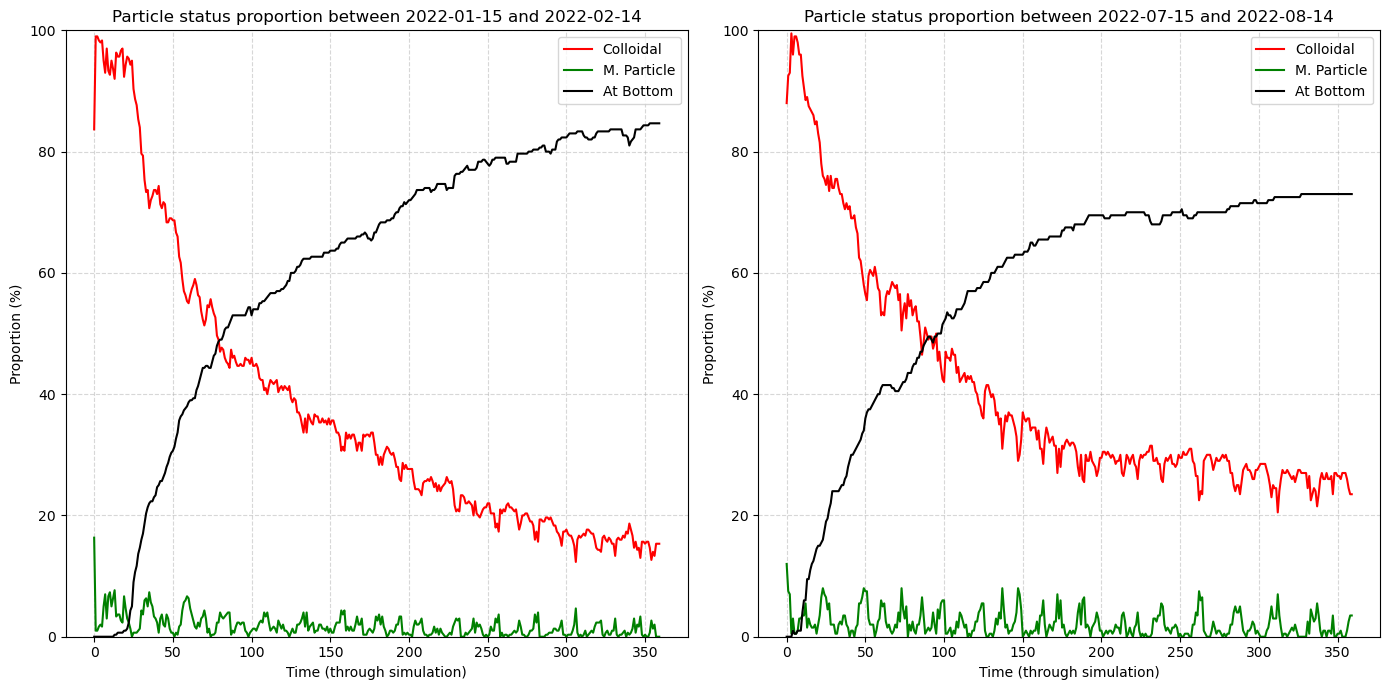

In [31]:
fig, ax = plt.subplots(1,2,figsize = (14,7))
#
ax[0].plot(JAN_colloidal*100, 'r', label = 'Colloidal')
ax[0].plot(JAN_marine*100, 'g', label = 'M. Particle')
ax[0].plot(JAN_bottom*100, 'k', label = 'At Bottom')
ax[0].set_ylabel('Proportion (%)')
ax[0].set_xlabel('Time (through simulation)')
ax[0].legend()
ax[0].grid(linestyle = '--', alpha = 0.5)
ax[0].set_title('Particle status proportion between ' + str(date_jan_start) + ' and ' + str(date_jan_end))
ax[0].set_ylim(0,100)
#
ax[1].plot(JUL_colloidal*100, 'r', label = 'Colloidal')
ax[1].plot(JUL_marine*100, 'g', label = 'M. Particle')
ax[1].plot(JUL_bottom*100, 'k', label = 'At Bottom')
ax[1].set_ylabel('Proportion (%)')
ax[1].set_xlabel('Time (through simulation)')
ax[1].legend()
ax[1].grid(linestyle = '--', alpha = 0.5)
ax[1].set_title('Particle status proportion between ' + str(date_jul_start) + ' and ' + str(date_jul_end))
ax[1].set_ylim(0,100)
#
plt.tight_layout()

Let's get bottom maps for comparisons with literature

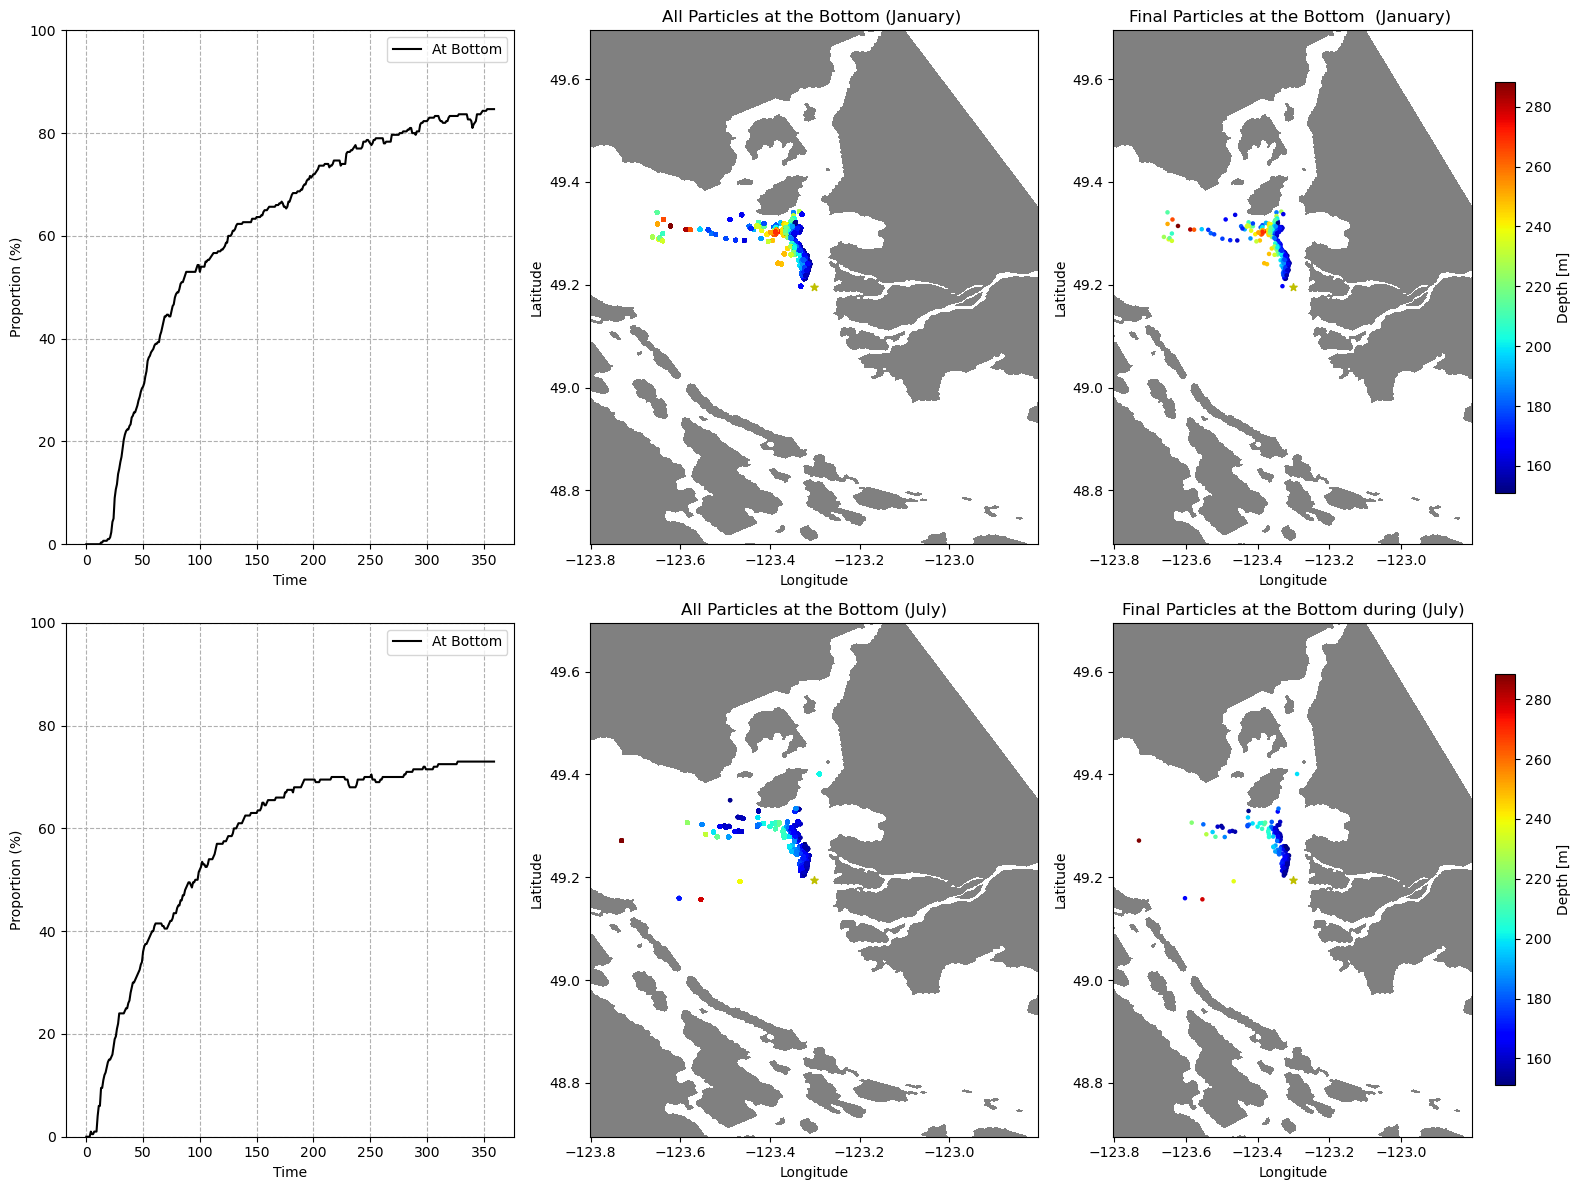

In [33]:
cmap = 'jet'
fig,axs=plt.subplots(2,3,figsize=(16,12))
# Make map
blevels = list(np.arange(0,500,100))
#
axs[0,0].plot(JAN_bottom*100, 'k', label = 'At Bottom')
axs[0,0].legend()
axs[0,0].set_xlabel('Time')
axs[0,0].set_ylabel('Proportion (%)')
axs[0,0].set_ylim(0,100)
axs[0,0].grid(linestyle = '--')
#
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
im = axs[0,1].scatter(ds_jan.lon.where(ds_jan.status == 4),ds_jan.lat.where(ds_jan.status == 4),zorder=3,c=depth_jan.where(ds_jan.status == 4), cmap = cmap ,s=5, label = 'At Bottom')
#
axs[0,1].scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs[0,1].set_ylim([clat[0]-.5,clat[0]+.5])
axs[0,1].set_xlim([clon[0]-.5,clon[0]+.5])
axs[0,1].set_title(f'All Particles at the Bottom (January) ')
axs[0,1].set_xlabel('Longitude')
axs[0,1].set_ylabel('Latitude')
#
#
axs[0,2].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,2].scatter(ds_jan.lon[:,-1].where(ds_jan.status[:,-1] == 4),ds_jan.lat[:,-1].where(ds_jan.status[:,-1] == 4),zorder=3,c=depth_jan[:,-1].where(ds_jan.status[:,-1] == 4), cmap = cmap,s=5)
#
axs[0,2].scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs[0,2].set_ylim([clat[0]-.5,clat[0]+.5])
axs[0,2].set_xlim([clon[0]-.5,clon[0]+.5])
axs[0,2].set_title(f'Final Particles at the Bottom  (January) ')
axs[0,2].set_xlabel('Longitude')
axs[0,2].set_ylabel('Latitude')
#
##
#
axs[1,0].plot(JUL_bottom*100, 'k', label = 'At Bottom')
axs[1,0].set_xlabel('Time')
axs[1,0].set_ylabel('Proportion (%)')
axs[1,0].set_ylim(0,100)
axs[1,0].grid(linestyle = '--')
axs[1,0].legend()
#
axs[1,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,1].scatter(ds_jul.lon.where(ds_jul.status == 4),ds_jul.lat.where(ds_jul.status == 4),zorder=3,c=depth_jul.where(ds_jul.status == 4), cmap = cmap,s=5)
#
axs[1,1].scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs[1,1].set_ylim([clat[0]-.5,clat[0]+.5])
axs[1,1].set_xlim([clon[0]-.5,clon[0]+.5])
axs[1,1].set_title(f'All Particles at the Bottom (July)')
axs[1,1].set_xlabel('Longitude')
axs[1,1].set_ylabel('Latitude')
#
axs[1,2].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,2].scatter(ds_jul.lon[:,-1].where(ds_jul.status[:,-1] == 4),ds_jul.lat[:,-1].where(ds_jul.status[:,-1] == 4),zorder=3,c=depth_jul[:,-1].where(ds_jul.status[:,-1] == 4), cmap = cmap,s=5)
#
axs[1,2].scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs[1,2].set_ylim([clat[0]-.5,clat[0]+.5])
axs[1,2].set_xlim([clon[0]-.5,clon[0]+.5])
axs[1,2].set_title(f'Final Particles at the Bottom during (July)')
axs[1,2].set_xlabel('Longitude')
axs[1,2].set_ylabel('Latitude')
#
cbar = fig.colorbar(im, ax=axs[0,2], location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
cbar = fig.colorbar(im, ax=axs[1,2], location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
plt.tight_layout()

**Lets check for a yearly run**

In [45]:
ds_year = xr.open_zarr('/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_run_PBDEs_365_days_1500_particles_20220101_1n_20230101_1n.zarr')
depth_year = ds_year.z*ds_year.fact
date_year_start = datetime(2022, 1, 1).strftime("%Y-%m-%d")
date_year_end  = (datetime(2022, 1, 1) + timedelta(365/2)).strftime("%Y-%m-%d")

Lets take a quick look at the distribution

(array([[1278.,    0.,    0., ...,    0.,    0.,    0.],
        [1474.,    0.,    0., ...,    0.,    0.,    0.],
        [1476.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [  30.,    0.,    0., ...,    0.,    0., 1470.],
        [  29.,    0.,    0., ...,    0.,    0., 1470.],
        [  28.,    0.,    0., ...,    0.,    0., 1470.]]),
 array([2.        , 2.20000005, 2.4000001 , 2.5999999 , 2.79999995,
        3.        , 3.20000005, 3.4000001 , 3.5999999 , 3.79999995,
        4.        ]),
 <a list of 4380 BarContainer objects>)

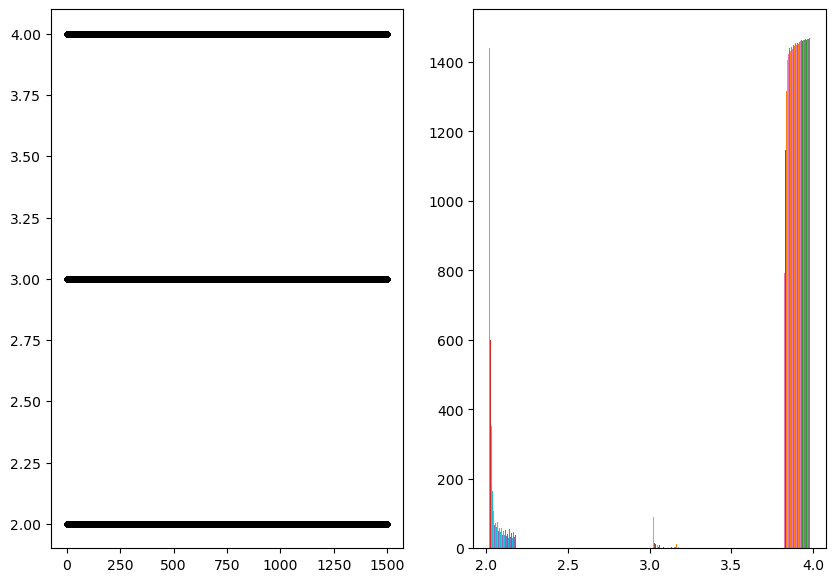

In [35]:
fig, ax = plt.subplots(1,2,figsize=(10,7))
ax[0].plot(ds_year.status, '.k')
ax[1].hist(ds_year.status)

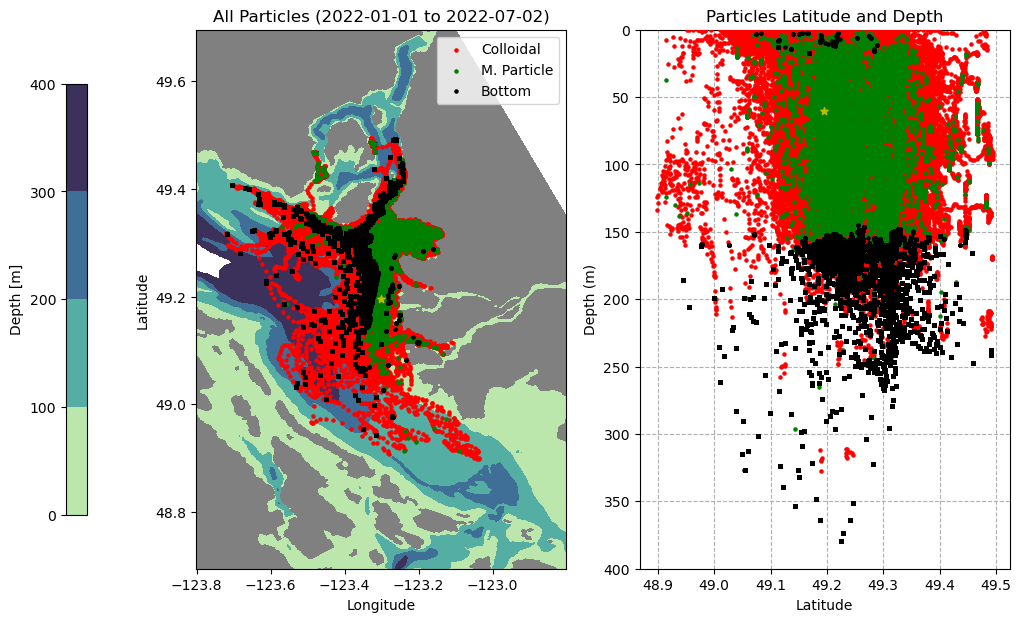

In [46]:
fig,axs=plt.subplots(1,2,figsize=(14,7))
# Make map
cmap = cmocean.cm.deep
blevels = list(np.arange(0,500,100))

im=axs[0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0].scatter(ds_year.lon.where(ds_year.status == 2),ds_year.lat.where(ds_year.status == 2),zorder=3,c='r',s=5, label = 'Colloidal')
axs[0].scatter(ds_year.lon.where(ds_year.status == 3),ds_year.lat.where(ds_year.status == 3),zorder=3,c='g',s=5, label = 'M. Particle')
axs[0].scatter(ds_year.lon.where(ds_year.status == 4),ds_year.lat.where(ds_year.status == 4),zorder=3,c='k',s=5, label = 'Bottom')
#
axs[0].legend()
axs[0].scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs[0].set_ylim([clat[0]-.5,clat[0]+.5])
axs[0].set_xlim([clon[0]-.5,clon[0]+.5])
axs[0].set_title(f'All Particles ('+ str(date_year_start) + ' to ' + str(date_year_end)+ ')')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
#
axs[1].scatter(ds_year.lat.where(ds_year.status == 2),depth_year.where(ds_year.status == 2),zorder=3,c='r',s=5)
axs[1].scatter(ds_year.lat.where(ds_year.status == 3),depth_year.where(ds_year.status == 3),zorder=3,c='g',s=5)
axs[1].scatter(ds_year.lat.where(ds_year.status == 4),depth_year.where(ds_year.status == 4),zorder=3,c='k',s=5)
#
axs[1].scatter(clat[0],dmin, zorder=3, c='y', marker='*',s=30)
axs[1].set_ylim([400,0])
axs[1].set_xlabel('Latitude')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title(f'Particles Latitude and Depth')
axs[1].grid(linestyle = '--')
#
cbar = fig.colorbar(im, ax=axs, location='left', shrink=0.8)
cbar.set_label('Depth [m]')

Text(0.5, 0.98, 'Final Particles positions from 2022-01-01 to 2022-07-02')

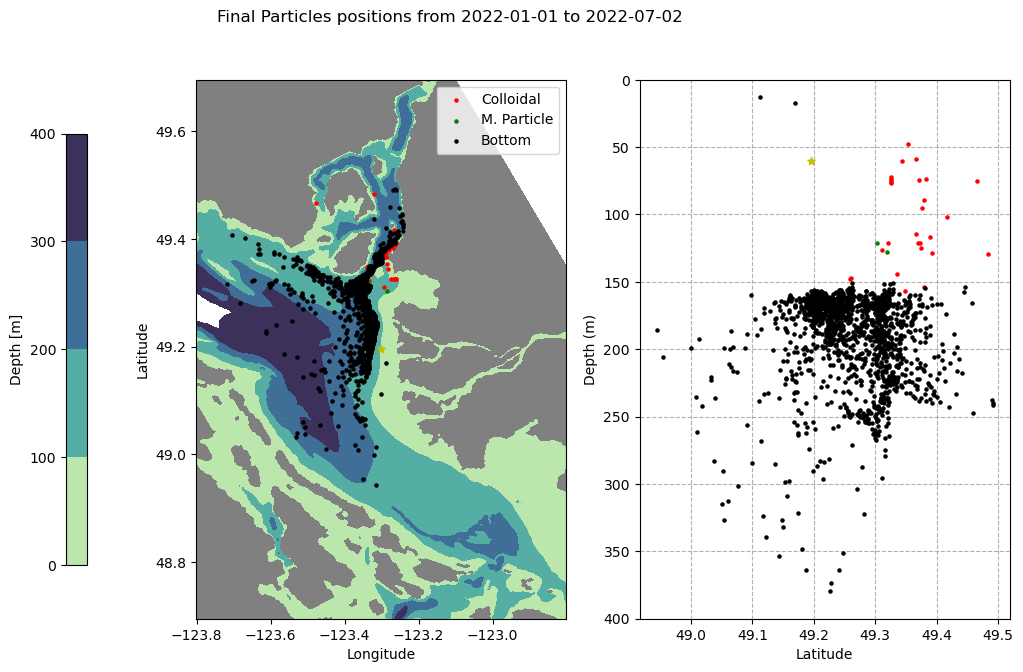

In [47]:
fig,axs=plt.subplots(1,2,figsize=(14,7))
# Make map
blevels = list(np.arange(0,500,100))

im=axs[0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0].scatter(ds_year.lon[:,-1].where(ds_year.status[:,-1] == 2),ds_year.lat[:,-1].where(ds_year.status[:,-1] == 2),zorder=3,c='r',s=5, label = 'Colloidal')
axs[0].scatter(ds_year.lon[:,-1].where(ds_year.status[:,-1] == 3),ds_year.lat[:,-1].where(ds_year.status[:,-1] == 3),zorder=3,c='g',s=5, label = 'M. Particle')
axs[0].scatter(ds_year.lon[:,-1].where(ds_year.status[:,-1] == 4),ds_year.lat[:,-1].where(ds_year.status[:,-1] == 4),zorder=3,c='k',s=5, label = 'Bottom')
#
axs[0].legend()
axs[0].scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs[0].set_ylim([clat[0]-.5,clat[0]+.5])
axs[0].set_xlim([clon[0]-.5,clon[0]+.5])
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
#
axs[1].scatter(ds_year.lat[:,-1].where(ds_year.status[:,-1] == 2),depth_year[:,-1].where(ds_year.status[:,-1] == 2),zorder=3,c='r',s=5)
axs[1].scatter(ds_year.lat[:,-1].where(ds_year.status[:,-1] == 3),depth_year[:,-1].where(ds_year.status[:,-1] == 3),zorder=3,c='g',s=5)
axs[1].scatter(ds_year.lat[:,-1].where(ds_year.status[:,-1] == 4),depth_year[:,-1].where(ds_year.status[:,-1] == 4),zorder=3,c='k',s=5)
#
axs[1].scatter(clat[0],dmin, zorder=3, c='y', marker='*',s=30)
axs[1].set_ylim([400,0])
axs[1].set_xlabel('Latitude')
axs[1].set_ylabel('Depth (m)')
axs[1].grid(linestyle = '--')
#
cbar = fig.colorbar(im, ax=axs, location='left', shrink=0.8)
cbar.set_label('Depth [m]')
#
plt.suptitle('Final Particles positions from ' + str(date_year_start) + ' to ' + str(date_year_end))

In [38]:
year_colloidal = []
year_marine = []
year_bottom = []
#
for i in range(len(ds_year.obs)):
    len_2_year = len(np.where(ds_year.status[:,i] == 2.)[0])
    len_3_year = len(np.where(ds_year.status[:,i] == 3.)[0])
    len_4_year = len(np.where(ds_year.status[:,i] == 4.)[0])   
    #
    year_colloidal.append(len_2_year)
    year_marine.append(len_3_year)
    year_bottom.append(len_4_year)
#    
YEAR_colloidal = np.array(year_colloidal)/len(ds_year.trajectory)
YEAR_marine = np.array(year_marine)/len(ds_year.trajectory)
YEAR_bottom = np.array(year_bottom)/len(ds_year.trajectory)

(0.0, 100.0)

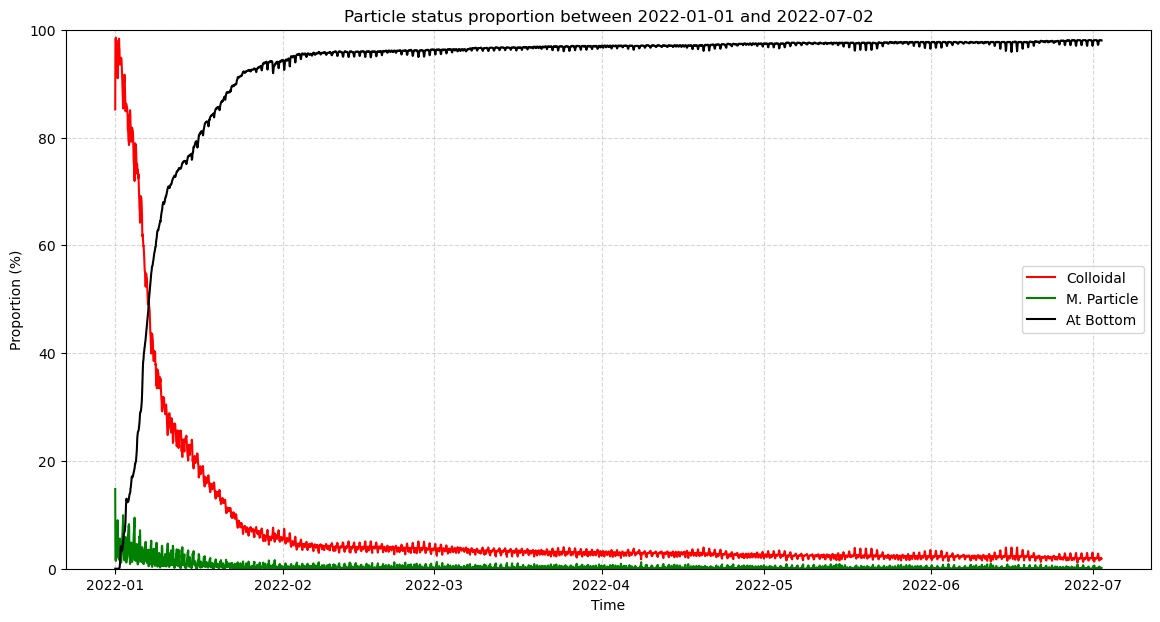

In [48]:
fig, ax = plt.subplots(figsize = (14,7))
#
ax.plot(ds_year.time[0,:].values, YEAR_colloidal*100, 'r', label = 'Colloidal')
ax.plot(ds_year.time[0,:].values, YEAR_marine*100, 'g', label = 'M. Particle')
ax.plot(ds_year.time[0,:].values, YEAR_bottom*100, 'k', label = 'At Bottom')
ax.set_ylabel('Proportion (%)')
ax.set_xlabel('Time')
ax.legend()
ax.grid(linestyle = '--', alpha = 0.5)
ax.set_title('Particle status proportion between ' + str(date_year_start) + ' and ' + str(date_year_end))
ax.set_ylim(0,100)

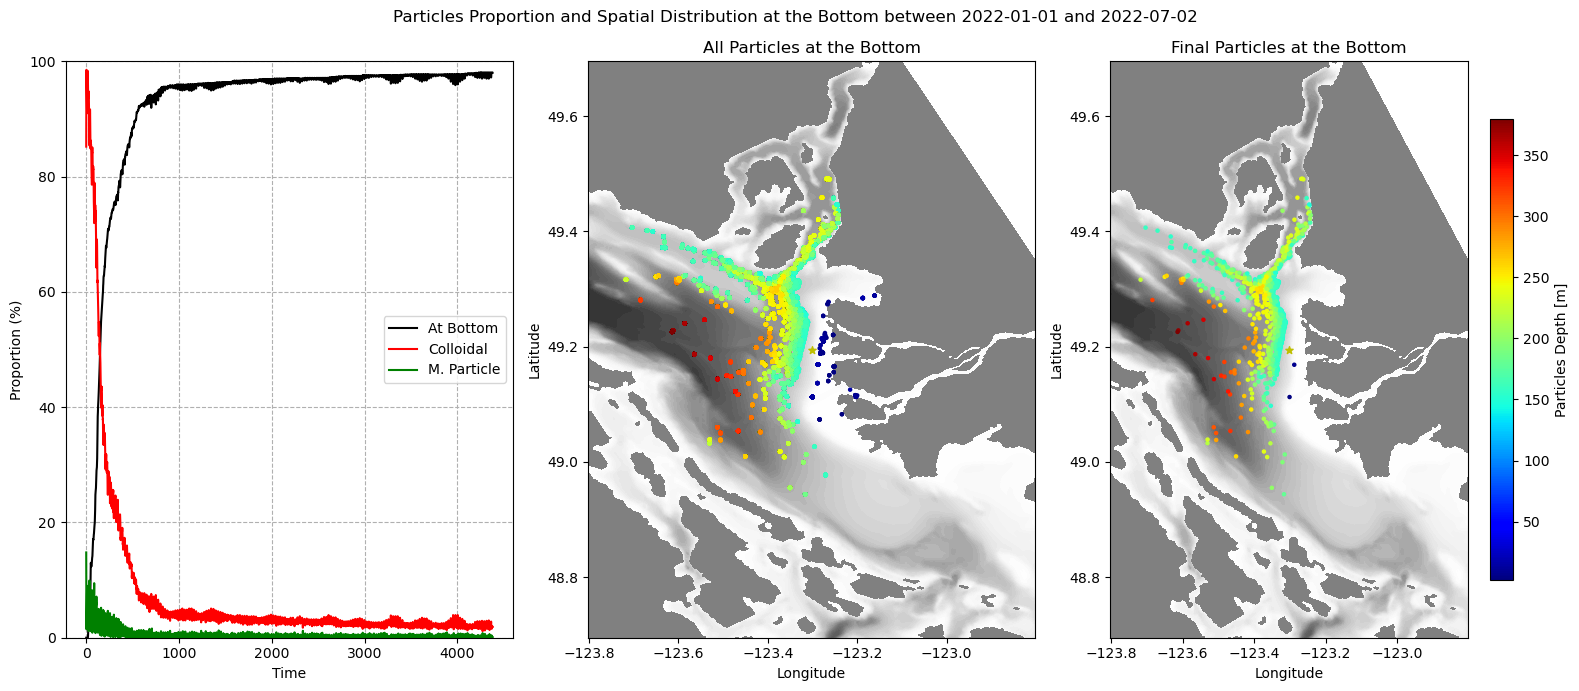

In [62]:
cmap = 'jet'
fig,axs=plt.subplots(1,3,figsize=(16,7))
# Make map
blevels = list(np.arange(0,500,10))
#
axs[0].plot(YEAR_bottom*100, 'k', label = 'At Bottom')
axs[0].plot(YEAR_colloidal*100, 'r', label = 'Colloidal')
axs[0].plot(YEAR_marine*100, 'g', label = 'M. Particle')
axs[0].legend()
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Proportion (%)')
axs[0].set_ylim(0,100)
axs[0].grid(linestyle = '--')
#
axs[1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,levels=blevels, cmap = 'Greys')
im = axs[1].scatter(ds_year.lon.where(ds_year.status == 4),ds_year.lat.where(ds_year.status == 4),zorder=3,c=depth_year.where(ds_year.status == 4), cmap = cmap ,s=5)
#
axs[1].scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs[1].set_ylim([clat[0]-.5,clat[0]+.5])
axs[1].set_xlim([clon[0]-.5,clon[0]+.5])
axs[1].set_title(f'All Particles at the Bottom')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
#
#
axs[2].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[2].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,levels=blevels, cmap = 'Greys')
axs[2].scatter(ds_year.lon[:,-1].where(ds_year.status[:,-1] == 4),ds_year.lat[:,-1].where(ds_year.status[:,-1] == 4),zorder=3,c=depth_year[:,-1].where(ds_year.status[:,-1] == 4), cmap = cmap,s=5)
#
axs[2].scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs[2].set_ylim([clat[0]-.5,clat[0]+.5])
axs[2].set_xlim([clon[0]-.5,clon[0]+.5])
axs[2].set_title(f'Final Particles at the Bottom')
axs[2].set_xlabel('Longitude')
axs[2].set_ylabel('Latitude')
#
cbar = fig.colorbar(im, ax=axs[2], location='right', shrink=0.8)
cbar.set_label('Particles Depth [m]')
#
plt.suptitle('Particles Proportion and Spatial Distribution at the Bottom between ' + str(date_year_start) + ' and ' + str(date_year_end))
plt.tight_layout()

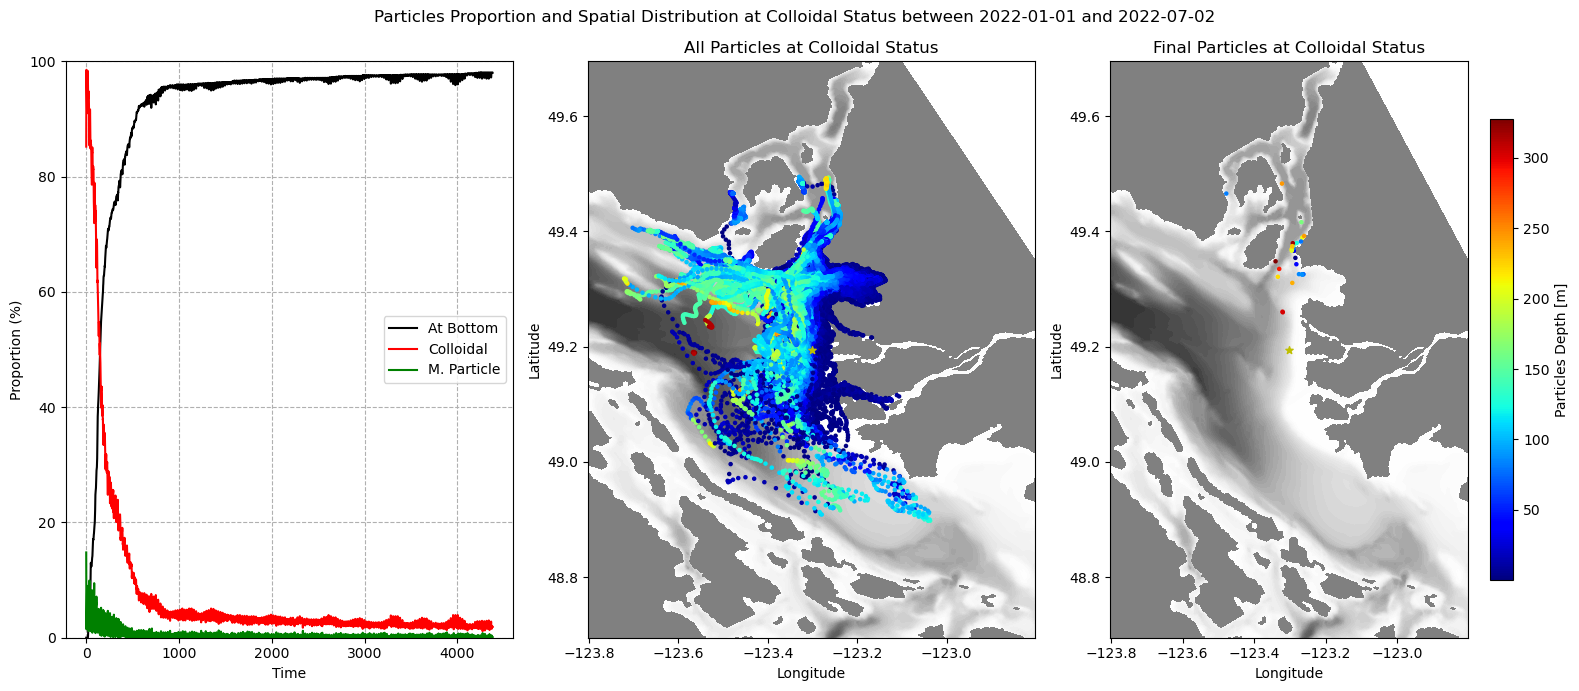

In [63]:
cmap = 'jet'
fig,axs=plt.subplots(1,3,figsize=(16,7))
# Make map
blevels = list(np.arange(0,500,10))
#
axs[0].plot(YEAR_bottom*100, 'k', label = 'At Bottom')
axs[0].plot(YEAR_colloidal*100, 'r', label = 'Colloidal')
axs[0].plot(YEAR_marine*100, 'g', label = 'M. Particle')
axs[0].legend()
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Proportion (%)')
axs[0].set_ylim(0,100)
axs[0].grid(linestyle = '--')
#
axs[1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,levels=blevels, cmap = 'Greys')
im = axs[1].scatter(ds_year.lon.where(ds_year.status == 2),ds_year.lat.where(ds_year.status == 2),zorder=3,c=depth_year.where(ds_year.status == 2), cmap = cmap ,s=5)
#
axs[1].scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs[1].set_ylim([clat[0]-.5,clat[0]+.5])
axs[1].set_xlim([clon[0]-.5,clon[0]+.5])
axs[1].set_title(f'All Particles at Colloidal Status')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
#
#
axs[2].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[2].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,levels=blevels, cmap = 'Greys')
axs[2].scatter(ds_year.lon[:,-1].where(ds_year.status[:,-1] == 2),ds_year.lat[:,-1].where(ds_year.status[:,-1] == 2),zorder=3,c=depth_year[:,-1].where(ds_year.status[:,-1] == 2), cmap = cmap,s=5)
#
axs[2].scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs[2].set_ylim([clat[0]-.5,clat[0]+.5])
axs[2].set_xlim([clon[0]-.5,clon[0]+.5])
axs[2].set_title(f'Final Particles at Colloidal Status')
axs[2].set_xlabel('Longitude')
axs[2].set_ylabel('Latitude')
#
cbar = fig.colorbar(im, ax=axs[2], location='right', shrink=0.8)
cbar.set_label('Particles Depth [m]')
#
plt.suptitle('Particles Proportion and Spatial Distribution at Colloidal Status between '  + str(date_year_start) + ' and ' + str(date_year_end))
plt.tight_layout()

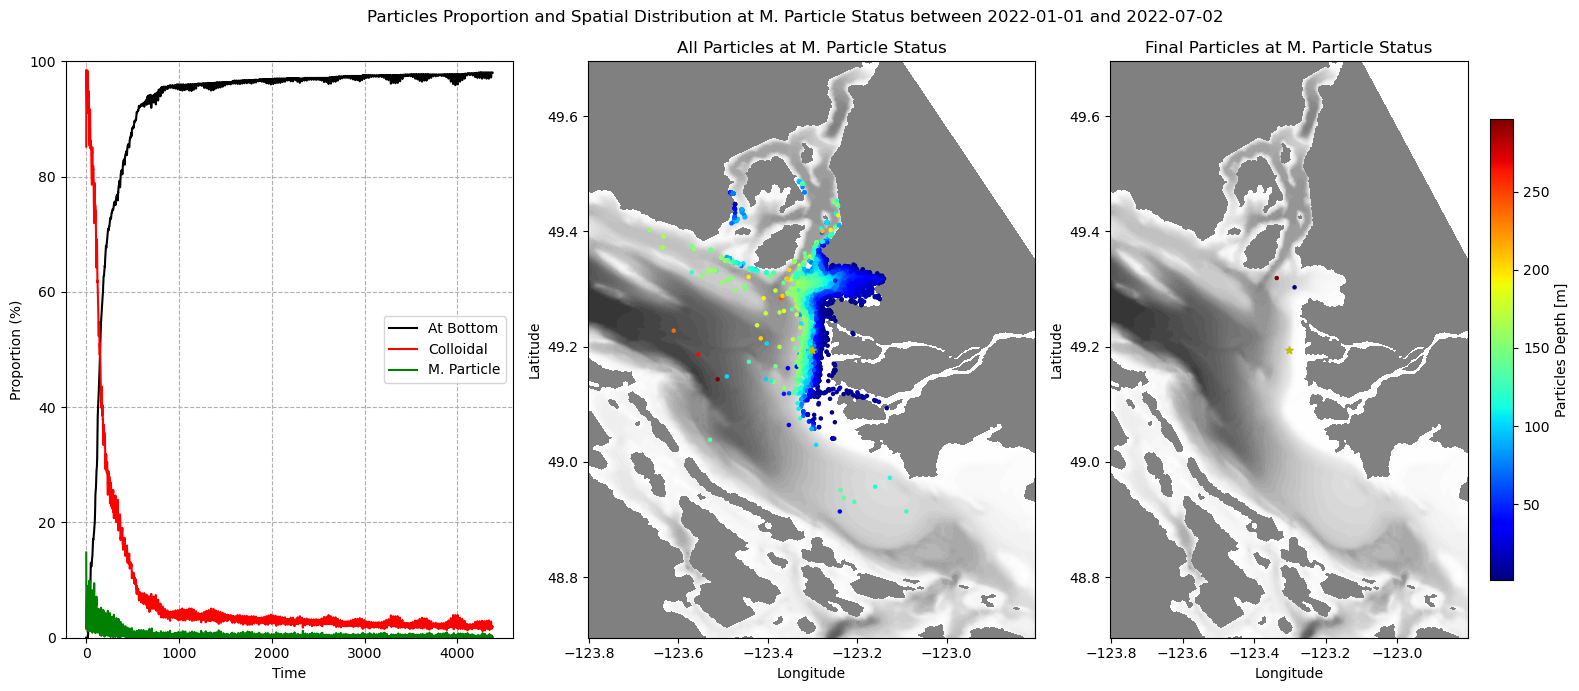

In [64]:
cmap = 'jet'
fig,axs=plt.subplots(1,3,figsize=(16,7))
# Make map
blevels = list(np.arange(0,500,10))
#
axs[0].plot(YEAR_bottom*100, 'k', label = 'At Bottom')
axs[0].plot(YEAR_colloidal*100, 'r', label = 'Colloidal')
axs[0].plot(YEAR_marine*100, 'g', label = 'M. Particle')
axs[0].legend()
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Proportion (%)')
axs[0].set_ylim(0,100)
axs[0].grid(linestyle = '--')
#
axs[1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,levels=blevels, cmap = 'Greys')
im = axs[1].scatter(ds_year.lon.where(ds_year.status == 3),ds_year.lat.where(ds_year.status == 3),zorder=3,c=depth_year.where(ds_year.status == 3), cmap = cmap ,s=5)
#
axs[1].scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs[1].set_ylim([clat[0]-.5,clat[0]+.5])
axs[1].set_xlim([clon[0]-.5,clon[0]+.5])
axs[1].set_title(f'All Particles at M. Particle Status')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
#
#
axs[2].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[2].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,levels=blevels, cmap = 'Greys')
axs[2].scatter(ds_year.lon[:,-1].where(ds_year.status[:,-1] == 3),ds_year.lat[:,-1].where(ds_year.status[:,-1] == 3),zorder=3,c=depth_year[:,-1].where(ds_year.status[:,-1] == 3), cmap = cmap,s=5)
#
axs[2].scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs[2].set_ylim([clat[0]-.5,clat[0]+.5])
axs[2].set_xlim([clon[0]-.5,clon[0]+.5])
axs[2].set_title(f'Final Particles at M. Particle Status')
axs[2].set_xlabel('Longitude')
axs[2].set_ylabel('Latitude')
#
cbar = fig.colorbar(im, ax=axs[2], location='right', shrink=0.8)
cbar.set_label('Particles Depth [m]')
#
plt.suptitle('Particles Proportion and Spatial Distribution at M. Particle Status between '  + str(date_year_start) + ' and ' + str(date_year_end))
plt.tight_layout()